# Модель распознавания лиц


В этой работе мы пытаемся внедрить модель распознавания лиц, используя свернутые нейронные сети

# Импорт библиотек

In [67]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Данные содержат обрезанные изображения лица 16 человек, распределенные по обучению и тестированию. Мы будем тренировать модель CNN, используя изображения из папки Training, а затем протестировать модель, используя невидимые изображения из тестовой папки, чтобы проверить, способна ли модель распознавать номер лица невидимых изображений или нет.



In [68]:
# Модель глубокого обучения CNN для распознавания лица
'''этот скрипт использует базу данных изображений и создает на ней модель CNN для тестирования
   правильно ли распознается данное изображение или нет'''
 
'''########Предварительная обработка изображений для обучения и тестирования данных#######'''
 
# Указать папку, в которой присутствуют изображения
TrainingImagePath='./Face_Images/Face Images/Final Training Images'
TestImagePath='Face_Images/Face Images/Final Testing Images/face13/2face13.jpg'
from keras.preprocessing.image import ImageDataGenerator

# Установка преобразований предварительной обработки на raw-изображениях данных обучения
# Эти гиперпараметры позволяют создавать слегка скрученные версии
# оригинального изображения, что приводит к лучшей модели, потому что он учится
# о хорошем и плохом смешении изображений
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
 
# Определение преобразований предварительной обработки в raw-изображениях тестовых данных
# Преобразование не выполняется на тестовых изображениях
test_datagen = ImageDataGenerator()
 
# Генерировать данные тренировки
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')
 
    
#Генерировать тестовые данные
test_set = test_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')
 
# Отображение тегов классов для каждой грани
test_set.class_indices

Found 244 images belonging to 16 classes.
Found 244 images belonging to 16 classes.


{'face1': 0,
 'face10': 1,
 'face11': 2,
 'face12': 3,
 'face13': 4,
 'face14': 5,
 'face15': 6,
 'face16': 7,
 'face2': 8,
 'face3': 9,
 'face4': 10,
 'face5': 11,
 'face6': 12,
 'face7': 13,
 'face8': 14,
 'face9': 15}

# Création d'un mappage pour les noms d'index et de visage

Словарь class_index выше имеет имена лиц в качестве ключей и числовое отображение в качестве значений. Нам нужно поменять его, потому что модель классификатора вернет ответ в виде числового сопоставления, и нам нужно извлечь из него имя лица.

Кроме того, поскольку это проблема классификации с несколькими классами, мы подсчитываем количество уникальных граней, поскольку это будет использоваться как количество выходных нейронов в выходном слое полностью связанного классификатора ANN.

In [69]:
'''########### Создание таблицы поиска для всех граней ############'''
# class_indices имеют числовой тег для каждой грани
TrainClasses=training_set.class_indices
 
# Сохранение лица и числового тега для дальнейшего использования
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName

    
#Сохранение карты лица для дальнейшего использования
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)

    
# Модель даст ответ в виде числового тега
# Это сопоставление поможет получить для него соответствующее имя лица
print("Mapping of Face and its ID",ResultMap)
 
# Число нейронов для выходного слоя равно числу граней
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'face1', 1: 'face10', 2: 'face11', 3: 'face12', 4: 'face13', 5: 'face14', 6: 'face15', 7: 'face16', 8: 'face2', 9: 'face3', 10: 'face4', 11: 'face5', 12: 'face6', 13: 'face7', 14: 'face8', 15: 'face9'}

 The Number of output neurons:  16


# Создание модели распознавания лиц CNN

В приведенном ниже фрагменте кода я создал шаблон CNN с

2 спрятанных слоя свертки

2 скрытых слоев pooling максимум

1 слой сведения

1 слой скрытой Энн

1 выходной слой с 16 нейронами (по одному для каждой грани)

Мы можем увеличить или уменьшить свертку, максимальное объединение, скрытые слои ANN и количество нейронов в них.


Просто имейте в виду, что чем больше слоев / нейронов мы добавляем, тем медленнее модель.


Кроме того, когда у нас есть большое количество изображений, порядка 50K и выше, процессор нашего ноутбука может быть неэффективным при изучении этих многочисленных изображений. Таким образом, это может заблокировать нашу работу.

Поскольку данные, которые мы использовали для демонстрации, невелики и содержат только 244 изображения для обучения, мы можем легко запустить его на нашем ноутбуке 


Помимо выбора наилучшего количества слоев и количества нейронов в нем, для каждого слоя также необходимо установить некоторые гипер-параметры.


Давайте немного объясним некоторые из важных гиперпараметров, которые мы будем использовать здесь


Filters = 32: это число указывает количество фильтров, которые мы используем для просмотра пикселей изображения во время этапа свертки. Некоторые фильтры могут захватывать острые края, некоторые фильтры могут захватывать цветовые вариации, некоторые фильтры могут захватывать контуры и т. д. В конечном счете, мы получаем важную информацию из изображений. В первом слое обычно используется количество фильтров = 32, а затем увеличивает мощность на 2. Как и в следующем слое, это 64, в следующем слое это 128 и так далее.

kernel_size = (5,5): это указывает на размер скользящего окна во время свертки, в этом примере мы используем скользящее окно размером 5X5 пикселей.

strides = (1, 1): Как быстро или медленно должно двигаться скользящее окно во время свертки. Мы используем самую низкую настройку 1X1 пикселей. Это означает перетаскивание окна свертки 5X5 (kernal_size) на 1 пиксель по оси x и 1 пиксель по оси У До тех пор, пока не будет прокручено все изображение.

input_shape = (64,64,3): изображения-это не что иное, как матрица цветового кода RGB. во время нашей предварительной обработки данных мы сжали изображения до 64X64, поэтому ожидаемая форма-64X64X3. Означает 3 массива 64X64, по одному для цветов RGB каждый.

kernel_initializer = 'uniform' : когда нейроны начинают вычисление, алгоритм должен определить значение каждого веса. Этот параметр указывает это. Вы можете выбрать различные значения, такие как» нормальный «или»glorot_uniform".

активация = 'relu': это указывает функцию активации для вычислений внутри каждого нейрона. Вы можете выбрать такие значения, как» перечитано«,» tanh«,» sigmoid " и т. д.

optimizer = 'adam': этот параметр позволяет найти оптимальные значения каждого веса в нейронной сети. 'adam' - один из самых полезных оптимизаторов, другой- 'rmsprop'

batch_size = 10: это указывает, сколько строк будет передаваться в сеть за один раз, после чего начнется вычисление SSE, и нейронная сеть начнет корректировать свои веса на основе ошибок.

Когда все строки передаются в партиях по 10 строк каждый, как указано в этом параметре, мы будем называть его epoch. Или полный цикл данных. Это также известно как мини-пакетный градиентный спуск. Небольшое значение batch_size заставит LSTM смотреть на данные медленно, например, 2 строки за раз или 4 строки за раз, что может привести к переназначению, по сравнению с высоким значением, таким как 20 или 50 строк за раз, что приведет к тому, что LSTM быстро просматривает данные, что может привести к подстройке. Поэтому соответствующее значение должно быть выбрано с помощью настройки гиперпараметров.
Epochs = 10 : одна и та же операция регулировки веса продолжается 10 раз, как указано в этом параметре. Проще говоря, LSTM рассматривает полные данные тренировки 10 раз и корректирует свои веса.

In [70]:
'''######################## Создание du модели CNN deep learning #######################'''
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from sklearn.metrics import accuracy_score
 
'''Инициализация сверточной нейронной сети'''
classifier= Sequential()
 
''' Шаг--1 Свертки
# Добавлен первый слой CNN
# мы используем формат (64,64,3), потому что мы используем бэкэнд TensorFlow
# Это означает 3 матрицы размера (64X64) пикселей, представляющих красные, зеленые и синие компоненты пикселей
'''
classifier.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(64,64,3), activation='relu'))
 
'''# Шаг--2 MAX Pooling'''
classifier.add(MaxPool2D(pool_size=(2,2)))
 
'''# Дополнительный слой свертки для лучшей точности '''
classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
 
classifier.add(MaxPool2D(pool_size=(2,2)))

'''# Шаг-3 сплющивание'''
classifier.add(Flatten())
 
'''# Шаг-4 Полностью Подключенная Нейронная Сеть'''
classifier.add(Dense(64, activation='relu'))
 
classifier.add(Dense(OutputNeurons, activation='softmax'))
 
'''# Компиляция CNN'''
#classifier.compiler(perte='binary_crossentropy', optimiseur='adam', métriques=['précision'])
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
 
###########################################################
import time
# Измерение времени, затраченного моделью на обучение
StartTime=time.time()
 
# Начало обучения модели
history = classifier.fit_generator(
                    training_set,                    
                    epochs=25,
                    validation_data=test_set,
                    validation_steps=10)


EndTime=time.time()
print("Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/25
8/8 [==============================] - 5s 576ms/step - loss: 88.5237 - accuracy: 0.0506 - val_loss: 3.9173 - val_accuracy: 0.0451
Epoch 2/25
8/8 [==============================] - 3s 374ms/step - loss: 3.1218 - accuracy: 0.1013
Epoch 3/25
8/8 [==============================] - 3s 368ms/step - loss: 2.1731 - accuracy: 0.3401
Epoch 4/25
8/8 [==============================] - 3s 370ms/step - loss: 1.4373 - accuracy: 0.5365
Epoch 5/25
8/8 [==============================] - 3s 358ms/step - loss: 0.5812 - accuracy: 0.8437
Epoch 6/25
8/8 [==============================] - 3s 384ms/step - loss: 0.3726 - accuracy: 0.9187
Epoch 7/25
8/8 [==============================] - 3s 381ms/step - loss: 0.2812 - accuracy: 0.9135
Epoch 8/25
8/8 [==============================] - 3s 372ms/step - loss: 0.2737 - accuracy: 0.9007
Epoch 9/25
8/8 [==============================] - 3s 358ms/step - loss: 0.1601 - accuracy: 0.9485
Epoch 10/25
8/8 [==============================] - 3s 356ms/step - loss: 0.

# Тестирование классификатора CNN на невидимых изображениях
Используя одно из изображений из папки тестовых данных, мы можем проверить, способна ли модель распознавать лицо.

TestImagePath позволяет выбрать любое изображение, которое модель не знает, и она сделает свое предсказание. Как мы попробуем следующий код

In [71]:

''' Создание одиночных прогнозов '''
import numpy as np
from keras.preprocessing import image
 
TestImagePath='Face_Images/Face Images/Final Testing Images/face2/1face2.jpg'
test_image=image.load_img(TestImagePath,target_size=(64, 64))
test_image=image.img_to_array(test_image)
 
test_image=np.expand_dims(test_image,axis=0)
 
result=classifier.predict(test_image,verbose=0)
#print(training_set.class_indices)
 
print('####'*10)
print('Prediction is: ',ResultMap[np.argmax(result)])

########################################
Prediction is:  face2


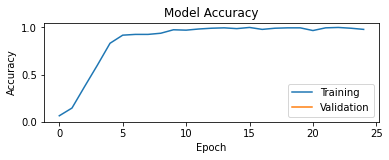

In [72]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')



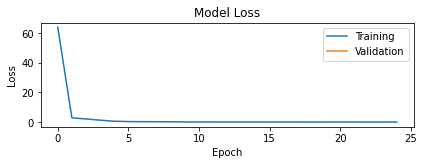

In [73]:
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

